<div class='alert'>

### Fine Tuning LLM

</div>

Transforming a foundation LLM into a solution that meets an applications's nees requires a process called *`fine-tuning`*.

A secondaryh process called *`distillation`* generates a small (fewer parameters) version of the fine-tuned model.

Despite the relatively tiny number of training examples, standard fine-tuning is often computationally expensive. That's because standard fine-tuning involves updating the weight and bias of every parameter on each backpropagation iteration. Fortunately, a smarter process called `parameter-efficient` tuning can fine-tune an LLM by adjusting only a `subset of parameters` on each backpropagation iteration.

A fine-tuned model's predictions are usually better than the foundation LLM's predictions. However, a fine-tuned model contains the same number of parameters as the foundation LLM. So, *if a foundation LLM contains ten billion parameters, then the fine-tuned version will also contain ten billion parameters*.

This is where distillation comes in.

*`Distillation`* creates a smaller version of an LLM. THe distilled LLM generates predictions much faster and requires fewer computational and environmental resources than the full LLM. However, the distilled model's predictions are generally not quite as good as the original LLM's predictions. 

*`Remember`*: LLMs with more parameters almost always generate better predictions than LLMs with fewer parameters.

Find more concepts here: https://developers.google.com/machine-learning/crash-course/llm/tuning

<div class='alert alert-success'>
Lets Start.

We will follow these steps:
1. Choose a pre-trained model and a dataset
2. Load the data
3. Tokenizer
4. Initialize our base model
5. Evaluate the method
6. Fine tune using the Trainer method
</div>

<div class='alert'>

#### 1. Choose a pre-trained model and a dataset

</div>

Lets use *`google-bert/bert-base-uncased`* model and a *`twitter dataset`*.

<div class='alert'>

#### 2. Load the dataset

</div>

In [1]:
# load the dataset
from datasets import load_dataset

twitter_dataset = load_dataset("mteb/tweet_sentiment_extraction")
twitter_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 27481
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'label_text'],
        num_rows: 3534
    })
})

In [2]:
import pandas as pd
import pprint

training_dataset = pd.DataFrame(twitter_dataset['train'])
testing_dataset = pd.DataFrame(twitter_dataset['test'])

training_dataset.set_index('id', inplace=True)
testing_dataset.set_index('id', inplace=True)

training_dataset.head()

,text,label,label_text
id,,,
cb774db0d1,"I`d have responded, if I were going",1,neutral
549e992a42,Sooo SAD I will miss you here in San Diego!!!,0,negative
088c60f138,my boss is bullying me...,0,negative
9642c003ef,what interview! leave me alone,0,negative
358bd9e861,"Sons of ****, why couldn`t they put them on t...",0,negative


In [3]:
training_dataset.shape, testing_dataset.shape, training_dataset['label_text'].unique()

((27481, 3),
 (3534, 3),
 array(['neutral', 'negative', 'positive'], dtype=object))

We see that the labels are `neutral`, `negative`, and `positive`.

So our goal is to classify the sentiment of the `text` into those `labels`

In [4]:
# check if the labels have balanced data
total_neutral = len(training_dataset[training_dataset['label'] == 1])
total_negative = len(training_dataset[training_dataset['label'] == 0])
total_positive = len(training_dataset[training_dataset['label'] == 2])

total_neutral, total_negative, total_positive

(11118, 7781, 8582)

<BarContainer object of 3 artists>

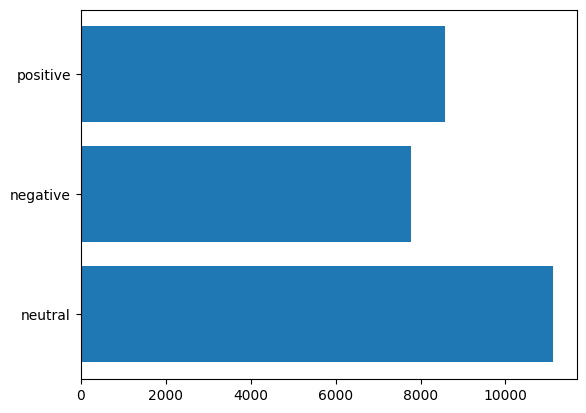

In [5]:
import matplotlib.pyplot as plt

plt.barh(['neutral', 'negative', 'positive'], [total_neutral, total_negative, total_positive])

Looks like neutral has more data. but its not a lot, so it is acceptable.

<div class='alert'>

#### 3. Load the tokenizer

</div>

In [6]:
# load the model
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased')

As LLMs work with tokens, we need to tokenize our entire dataset using the tokenizer.

We can use map method to apply the preprocessing function over the entire dataset.

In [7]:
from transformers import GPT2Tokenizer
# d = load_dataset("mteb/tweet_sentiment_extraction")

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# t.pad_token

In [8]:
# tokenizer.pad_token = tokenizer.eos_token

def tokenize_function(observation):
    return tokenizer(observation['text'], padding='max_length', truncation=True)

tokenized_dataset = twitter_dataset.map(tokenize_function, batched=True)


In [9]:
tokenized_dataset['train'], tokenized_dataset['test']

(Dataset({
     features: ['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'],
     num_rows: 27481
 }),
 Dataset({
     features: ['id', 'text', 'label', 'label_text', 'input_ids', 'attention_mask'],
     num_rows: 3534
 }))

<div class='alert'>

#### 4. Initialize our base model

</div>

In [10]:
# model = AutoModelForMaskedLM.from_pretrained('google-bert/bert-base-uncased', num_labels=3)

from transformers import GPT2ForSequenceClassification

model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=3)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<div class='alert'>

#### 5. Evaluate

</div>

In [11]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   return metric.compute(predictions=predictions, references=labels)

<div class='alert'>

#### 6. Fine-tune the model

</div>

In [12]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
   output_dir="test_trainer",
   #evaluation_strategy="epoch",
   per_device_train_batch_size=1,  # Reduce batch size here
   per_device_eval_batch_size=1,    # Optionally, reduce for evaluation as well
   gradient_accumulation_steps=4
)


trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_dataset['train'],
   eval_dataset=tokenized_dataset['test'],
   compute_metrics=compute_metrics,

)

trainer.train()


Step,Training Loss
500,0.883400
1000,0.723400
1500,0.725400
2000,0.719200
2500,0.657300
3000,0.681800
3500,0.663300
4000,0.655700
4500,0.669000
5000,0.679600


TrainOutput(global_step=20610, training_loss=0.5891319002820589, metrics={'train_runtime': 13970.0241, 'train_samples_per_second': 5.901, 'train_steps_per_second': 1.475, 'total_flos': 4.307986164901478e+16, 'train_loss': 0.5891319002820589, 'epoch': 2.9996725010006915})